## [SECTION 1] SETUP & IMPORT LIBRARIES

In [18]:
# Data Processing
import pandas as pd
import numpy as np
import re
from datetime import datetime, time, timedelta

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import Search, Fullscreen, MiniMap

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Semua libraries berhasil diimport!")

✅ Semua libraries berhasil diimport!


## [SECTION 2] HELPER FUNCTIONS - Sinkron dengan app.py

In [19]:
# === FUNGSI HELPER DARI app.py ===

def parse_time_to_decimal(time_str):
    """Parse time string (H.M atau H:M) to decimal hours.
    Contoh: '20.30' atau '20:30' → 20.5
    """
    if pd.isna(time_str) or str(time_str).strip() in ['-', 'nan', '']:
        return np.nan
    
    s = str(time_str).strip()
    # Handle both . dan : sebagai separator
    s = s.replace('.', ':')
    
    try:
        parts = s.split(':')
        h = int(parts[0])
        m = int(parts[1]) if len(parts) > 1 else 0
        # Ensure 2-digit minute
        if m < 10 and len(parts) > 1 and len(parts[1]) == 1:
            m = m * 10
        return h + m / 60.0
    except:
        return np.nan

def konversi_jam(x):
    """Convert jam range (e.g., '20.00-22.00') to decimal average.
    Handle midnight wraparound (e.g., 22.00-02.00 → 22→26).
    """
    if pd.isna(x) or str(x).strip() in ['-', 'nan', '']:
        return np.nan
    
    s = str(x).strip()
    parts = re.split(r'\s*-\s*', s)
    
    if len(parts) < 2:
        return parse_time_to_decimal(parts[0])
    
    start = parse_time_to_decimal(parts[0])
    end = parse_time_to_decimal(parts[1])
    
    if pd.isna(start) or pd.isna(end):
        return np.nan
    
    # Handle midnight wraparound
    if start > end:
        end += 24
    
    return (start + end) / 2.0

def time_to_decimal_hour(time_obj):
    """Convert datetime.time object to decimal hours."""
    if isinstance(time_obj, str):
        try:
            time_obj = datetime.strptime(time_obj, '%H:%M').time()
        except:
            return np.nan
    return time_obj.hour + time_obj.minute / 60.0

def kategori_jam_otomatis(jam):
    """Auto-categorize time into Sepi/Sedang/Ramai."""
    jam = float(jam)
    if jam <= 6.0 or jam >= 22.0:
        return 'Sepi'
    elif jam > 8.0 and jam <= 19.0:
        return 'Ramai'
    else:
        return 'Sedang'

def calculate_progresif_tarif(jenis, potensi_class, jam_desimal):
    """Calculate progressive tariff based on time and class.
    Jika jam > 9, tambahan Rp1000 untuk Tinggi, Rp500 untuk Sedang.
    """
    tarif_mapping = {
        'Motor': {'Rendah': 1000, 'Sedang': 2000, 'Tinggi': 3000},
        'Mobil': {'Rendah': 3000, 'Sedang': 4000, 'Tinggi': 5000}
    }
    
    base_tarif = tarif_mapping[jenis].get(potensi_class, 0)
    
    if jam_desimal > 9.0:
        if potensi_class == 'Tinggi':
            return base_tarif + 1000
        elif potensi_class == 'Sedang':
            return base_tarif + 500
    
    return base_tarif

print("✅ Fungsi helper berhasil dibuat (sinkron dengan app.py)")

✅ Fungsi helper berhasil dibuat (sinkron dengan app.py)


## [SECTION 3] DATA LOADING & PREPROCESSING

In [20]:
print("\n" + "="*90)
print("[STEP 1] LOAD DATA")
print("="*90)

FILE_PATH = 'DataParkir_Fix.xlsx'

try:
    df_raw = pd.read_excel(FILE_PATH)
    df = df_raw.copy()
    print(f"✅ Data berhasil dimuat dari: {FILE_PATH}")
    print(f"   Shape: {df.shape[0]} baris × {df.shape[1]} kolom")
except FileNotFoundError:
    print(f"❌ File {FILE_PATH} tidak ditemukan")
    print("   Upload file terlebih dahulu untuk Google Colab")
    df = pd.DataFrame()

print(f"\nPreview Data:")
print(df.head())

if not df.empty:
    print(f"\n✓ Kolom yang tersedia: {list(df.columns[:5])}...")
    print(f"✓ Tipe data: {dict(df.dtypes)}")


[STEP 1] LOAD DATA
✅ Data berhasil dimuat dari: DataParkir_Fix.xlsx
   Shape: 407 baris × 39 kolom

Preview Data:
             Titik  Latitude  Longitude Jam Ramai Mobil Weekday  \
0              NaN       NaN        NaN                     NaN   
1      Toko Satria  -7.42741  109.24381             15.00-17.00   
2       Toko Mlati  -7.42725  109.24364             14.00-16.00   
3      Toko Pagoda  -7.42717  109.24364             13.00-15.00   
4  Matahari Bazzar  -7.42921  109.23951             18.00-21.00   

  Jam Ramai Motor Weekend Jam Ramai Mobil Weekend Jam Ramai Motor Weekday  \
0                     NaN                     NaN                     NaN   
1             15.00-17.00             15.00-17.00             15.00-17.00   
2             14.00-16.00             14.00-16.00             14.00-16.00   
3             13.00-15.00             13.00-15.00             13.00-15.00   
4             18.00-21.00             18.00-21.00             18.00-21.00   

  Jam Sedang Motor 

In [22]:
print("\n" + "="*90)
print("[STEP 2] DATA CLEANING & PREPROCESSING")
print("="*90)

# Identify column types
pend_cols = [c for c in df.columns if c.startswith('Pendapatan Tarif Parkir')]
jam_cols = [c for c in df.columns if 'Jam' in c and 'per tahun' not in c]
jumlah_cols = [c for c in df.columns if c.startswith('Jumlah')]

print(f"\n✓ Identified columns:")
print(f"  Pendapatan: {len(pend_cols)} | Jam: {len(jam_cols)} | Jumlah: {len(jumlah_cols)}")

# Clean pendapatan columns - ROBUST VERSION
print("\n[2.1] Cleaning Pendapatan columns...")
for col in pend_cols:
    if col in df.columns:
        try:
            # Convert to string, handle nan/NaN values
            df[col] = df[col].astype(str).str.strip()
            
            # Replace common placeholders
            df[col] = df[col].replace(['nan', 'NaN', '', '-'], '0')
            
            # Remove all non-numeric characters except comma and period
            df[col] = df[col].str.replace(r'[^\d,\.]', '', regex=True)
            
            # Handle empty strings
            df[col] = df[col].replace('', '0')
            
            # Remove thousand separators (.), replace decimal comma with period
            df[col] = df[col].str.replace('.', '', regex=False)
            df[col] = df[col].str.replace(',', '.', regex=False)
            
            # Convert to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(float)
        except Exception as e:
            print(f"  ⚠ Warning cleaning {col}: {e}")
            df[col] = 0.0

print("✅ Pendapatan columns cleaned (all converted to float)")

# Convert jam columns
print("\n[2.2] Converting Jam columns to decimal hours...")
for col in jam_cols:
    df[col] = df[col].apply(konversi_jam)
    mean_val = df[col].mean()
    df[col] = df[col].fillna(mean_val)
print(f"✅ {len(jam_cols)} Jam columns converted")

# Handle missing values
print("\n[2.3] Handling missing values...")
for col in df.columns:
    if df[col].dtype != 'object':
        df[col] = df[col].fillna(df[col].median())
    else:
        if df[col].isnull().any():
            mode_val = df[col].mode()
            if len(mode_val) > 0:
                df[col] = df[col].fillna(mode_val[0])
print(f"✅ Missing values handled")

# Drop rows without location info
print("\n[2.4] Removing rows without location (Titik, Lat, Lon)...")
before = len(df)
df['Titik'] = df['Titik'].astype(str).str.strip()
df = df.replace({'Titik': {'nan': None}})
df = df.dropna(subset=['Titik', 'Latitude', 'Longitude']).reset_index(drop=True)
after = len(df)
print(f"✅ Removed {before - after} rows without location")

print(f"\n✅ Data shape after preprocessing: {df.shape}")
print(df.head(3))


[STEP 2] DATA CLEANING & PREPROCESSING

✓ Identified columns:
  Pendapatan: 8 | Jam: 12 | Jumlah: 4

[2.1] Cleaning Pendapatan columns...
✅ Pendapatan columns cleaned (all converted to float)

[2.2] Converting Jam columns to decimal hours...
✅ 12 Jam columns converted

[2.3] Handling missing values...
✅ Missing values handled

[2.4] Removing rows without location (Titik, Lat, Lon)...
✅ Removed 0 rows without location

✅ Data shape after preprocessing: (407, 39)
         Titik  Latitude   Longitude  Jam Ramai Mobil Weekday  \
0    Indomaret -7.423387  109.242693                13.946742   
1  Toko Satria -7.427410  109.243810                16.000000   
2   Toko Mlati -7.427250  109.243640                15.000000   

   Jam Ramai Motor Weekend  Jam Ramai Mobil Weekend  Jam Ramai Motor Weekday  \
0                13.953358                13.932107                13.948892   
1                16.000000                16.000000                16.000000   
2                15.000000      

## [SECTION 4] FEATURE ENGINEERING & CLASSIFICATION

In [23]:
print("\n" + "="*90)
print("[STEP 3] FEATURE ENGINEERING & CLASSIFICATION TARGET")
print("="*90)

# Verify all pendapatan columns are numeric
print("\n[3.0] Verifying data types...")
pend_cols_check = [c for c in pend_cols if c in df.columns]
for col in pend_cols_check:
    if df[col].dtype not in ['float64', 'float32', 'int64', 'int32']:
        print(f"  ⚠ Converting {col} to float...")
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(float)
print("✅ All data types verified")

# Calculate total revenue
motor_pend_cols = [c for c in pend_cols if 'Motor' in c]
mobil_pend_cols = [c for c in pend_cols if 'Mobil' in c]

print(f"\n[3.1] Calculating Total Pendapatan...")
print(f"  Motor columns: {motor_pend_cols}")
print(f"  Mobil columns: {mobil_pend_cols}")

# Ensure columns exist and are numeric
motor_pend_cols = [c for c in motor_pend_cols if c in df.columns]
mobil_pend_cols = [c for c in mobil_pend_cols if c in df.columns]

df['Total_Pend_Motor'] = df[motor_pend_cols].astype(float).sum(axis=1)
df['Total_Pend_Mobil'] = df[mobil_pend_cols].astype(float).sum(axis=1)

print(f"\n[3.1] Total Pendapatan calculated:")
print(f"  Motor - Mean: Rp{df['Total_Pend_Motor'].mean():,.0f}")
print(f"  Motor - Median: Rp{df['Total_Pend_Motor'].median():,.0f}")
print(f"  Mobil - Mean: Rp{df['Total_Pend_Mobil'].mean():,.0f}")
print(f"  Mobil - Median: Rp{df['Total_Pend_Mobil'].median():,.0f}")

# Classification using qcut with fallback to cut
print("\n[3.2] Klasifikasi Potensi Tarif (Rendah/Sedang/Tinggi)...")
try:
    df['Class_Motor'] = pd.qcut(df['Total_Pend_Motor'], q=3, labels=['Rendah','Sedang','Tinggi'], duplicates='drop')
    batas_motor = df['Total_Pend_Motor'].quantile([0.333, 0.666]).drop_duplicates().sort_values()
except ValueError:
    print("  ⚠ qcut failed, using cut...")
    df['Class_Motor'] = pd.cut(df['Total_Pend_Motor'], bins=[-np.inf, df['Total_Pend_Motor'].median(), np.inf], labels=['Rendah', 'Tinggi']).fillna('Rendah')
    batas_motor = df['Total_Pend_Motor'].quantile([0.5]).drop_duplicates().sort_values()

try:
    df['Class_Mobil'] = pd.qcut(df['Total_Pend_Mobil'], q=3, labels=['Rendah','Sedang','Tinggi'], duplicates='drop')
    batas_mobil = df['Total_Pend_Mobil'].quantile([0.333, 0.666]).drop_duplicates().sort_values()
except ValueError:
    print("  ⚠ qcut failed, using cut...")
    df['Class_Mobil'] = pd.cut(df['Total_Pend_Mobil'], bins=[-np.inf, df['Total_Pend_Mobil'].median(), np.inf], labels=['Rendah', 'Tinggi']).fillna('Rendah')
    batas_mobil = df['Total_Pend_Mobil'].quantile([0.5]).drop_duplicates().sort_values()

print(f"\n✅ Classification complete")
print(f"\nMotor distribution:")
print(df['Class_Motor'].value_counts().sort_index())
print(f"\nMobil distribution:")
print(df['Class_Mobil'].value_counts().sort_index())

# Display quantile boundaries
print("\n" + "="*90)
print("💰 BATAS KUANTIL TOTAL PENDAPATAN TAHUNAN (RUPIAH)")
print("="*90)

print(f"\n--- MOTOR ---")
if len(batas_motor) >= 2:
    print(f"  Rendah  : Pendapatan < Rp{batas_motor.iloc[0]:,.0f}")
    print(f"  Sedang  : Rp{batas_motor.iloc[0]:,.0f} s/d Rp{batas_motor.iloc[1]:,.0f}")
    print(f"  Tinggi  : Pendapatan > Rp{batas_motor.iloc[1]:,.0f}")
else:
    print(f"  Rendah  : Pendapatan < Rp{batas_motor.iloc[0]:,.0f}")
    print(f"  Tinggi  : Pendapatan > Rp{batas_motor.iloc[0]:,.0f}")

print(f"\n--- MOBIL ---")
if len(batas_mobil) >= 2:
    print(f"  Rendah  : Pendapatan < Rp{batas_mobil.iloc[0]:,.0f}")
    print(f"  Sedang  : Rp{batas_mobil.iloc[0]:,.0f} s/d Rp{batas_mobil.iloc[1]:,.0f}")
    print(f"  Tinggi  : Pendapatan > Rp{batas_mobil.iloc[1]:,.0f}")
else:
    print(f"  Rendah  : Pendapatan < Rp{batas_mobil.iloc[0]:,.0f}")
    print(f"  Tinggi  : Pendapatan > Rp{batas_mobil.iloc[0]:,.0f}")


[STEP 3] FEATURE ENGINEERING & CLASSIFICATION TARGET

[3.0] Verifying data types...
✅ All data types verified

[3.1] Calculating Total Pendapatan...
  Motor columns: ['Pendapatan Tarif Parkir Weekday Motor', 'Pendapatan Tarif Parkir Weekend Motor', 'Pendapatan Tarif Parkir Weekday Motor per tahun', 'Pendapatan Tarif Parkir Weekend Motor per tahun']
  Mobil columns: ['Pendapatan Tarif Parkir Weekday Mobil', 'Pendapatan Tarif Parkir Weekend Mobil', 'Pendapatan Tarif Parkir Weekday Mobil per tahun', 'Pendapatan Tarif Parkir Weekend Mobil per tahun']

[3.1] Total Pendapatan calculated:
  Motor - Mean: Rp185,877,193
  Motor - Median: Rp139,968,114
  Mobil - Mean: Rp16,080,274
  Mobil - Median: Rp12,844,000

[3.2] Klasifikasi Potensi Tarif (Rendah/Sedang/Tinggi)...

✅ Classification complete

Motor distribution:
Class_Motor
Rendah    136
Sedang    135
Tinggi    136
Name: count, dtype: int64

Mobil distribution:
Class_Mobil
Rendah    136
Sedang    135
Tinggi    136
Name: count, dtype: int64


## [SECTION 5] RANDOM FOREST MODEL TRAINING

In [24]:
print("\n" + "="*90)
print("[STEP 4] PREPARE FEATURES & TRAIN MODELS")
print("="*90)

# Define features
fitur_motor = ['Jumlah Motor Weekday', 'Jumlah Motor Weekend'] + [c for c in jam_cols if 'Motor' in c]
fitur_mobil = ['Jumlah Mobil Weekday', 'Jumlah Mobil Weekend'] + [c for c in jam_cols if 'Mobil' in c]

print(f"\n[4.1] Features defined:")
print(f"  Motor: {len(fitur_motor)} fitur")
for i, f in enumerate(fitur_motor[:3], 1): print(f"    {i}. {f}")
print(f"    ... ({len(fitur_motor)-3} more)")

print(f"\n  Mobil: {len(fitur_mobil)} fitur")
for i, f in enumerate(fitur_mobil[:3], 1): print(f"    {i}. {f}")
print(f"    ... ({len(fitur_mobil)-3} more)")

# Prepare X, y
X_motor = df[fitur_motor].copy()
y_motor = df['Class_Motor'].copy()
X_mobil = df[fitur_mobil].copy()
y_mobil = df['Class_Mobil'].copy()

# Encode target
le_motor = LabelEncoder()
y_motor_enc = le_motor.fit_transform(y_motor)

le_mobil = LabelEncoder()
y_mobil_enc = le_mobil.fit_transform(y_mobil)

print(f"\n[4.2] Data prepared:")
print(f"  X_motor: {X_motor.shape} | y_motor: {y_motor.shape}")
print(f"  X_mobil: {X_mobil.shape} | y_mobil: {y_mobil.shape}")

# Split data - 80:20
print(f"\n[4.3] Splitting data (80:20 train:test)...")
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_motor, y_motor_enc, test_size=0.2, random_state=42, stratify=y_motor_enc
)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_mobil, y_mobil_enc, test_size=0.2, random_state=42, stratify=y_mobil_enc
)

print(f"  Motor: Train {len(X_train_m)} | Test {len(X_test_m)}")
print(f"  Mobil: Train {len(X_train_c)} | Test {len(X_test_c)}")

# Train models - 150 trees dengan max_depth=15
print(f"\n[4.4] Training Random Forest (n_estimators=150, max_depth=15, min_samples_leaf=3)...")

model_motor = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
model_motor.fit(X_train_m, y_train_m)
print("  ✅ Motor model trained")

model_mobil = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
model_mobil.fit(X_train_c, y_train_c)
print("  ✅ Mobil model trained")

print(f"\n✅ Both models trained successfully!")


[STEP 4] PREPARE FEATURES & TRAIN MODELS

[4.1] Features defined:
  Motor: 8 fitur
    1. Jumlah Motor Weekday
    2. Jumlah Motor Weekend
    3. Jam Ramai Motor Weekend
    ... (5 more)

  Mobil: 8 fitur
    1. Jumlah Mobil Weekday
    2. Jumlah Mobil Weekend
    3. Jam Ramai Mobil Weekday
    ... (5 more)

[4.2] Data prepared:
  X_motor: (407, 8) | y_motor: (407,)
  X_mobil: (407, 8) | y_mobil: (407,)

[4.3] Splitting data (80:20 train:test)...
  Motor: Train 325 | Test 82
  Mobil: Train 325 | Test 82

[4.4] Training Random Forest (n_estimators=150, max_depth=15, min_samples_leaf=3)...
  ✅ Motor model trained
  ✅ Mobil model trained

✅ Both models trained successfully!


## [SECTION 6] MODEL EVALUATION & METRICS

In [25]:
print("\n" + "="*90)
print("[STEP 5] MODEL EVALUATION & TRAINING METRICS")
print("="*90)

# Make predictions with full model
y_pred_m = model_motor.predict(X_test_m)
y_pred_c = model_mobil.predict(X_test_c)

# Calculate training metrics untuk setiap jumlah pohon (seperti di app.py)
# MOTOR
print("\n[5.1] Calculating cumulative training metrics for Motor...")
tree_counts = []
train_scores_m = []
test_scores_m = []

for n_trees in range(10, 151, 10):
    # Aggregate predictions dari n_trees pertama
    y_pred_train_prob = np.zeros((len(y_train_m), len(le_motor.classes_)))
    y_pred_test_prob = np.zeros((len(y_test_m), len(le_motor.classes_)))
    
    for estimator in model_motor.estimators_[:n_trees]:
        y_pred_train_prob += estimator.predict_proba(X_train_m)
        y_pred_test_prob += estimator.predict_proba(X_test_m)
    
    # Majority voting
    y_pred_train_final = np.argmax(y_pred_train_prob, axis=1)
    y_pred_test_final = np.argmax(y_pred_test_prob, axis=1)
    
    # Calculate accuracy
    train_acc = np.mean(y_pred_train_final == y_train_m)
    test_acc = np.mean(y_pred_test_final == y_test_m)
    
    train_scores_m.append(train_acc)
    test_scores_m.append(test_acc)
    tree_counts.append(n_trees)

print(f"✅ Motor metrics calculated for {len(tree_counts)} tree milestones")

# MOBIL
print("\n[5.2] Calculating cumulative training metrics for Mobil...")
train_scores_c = []
test_scores_c = []

for n_trees in range(10, 151, 10):
    # Aggregate predictions dari n_trees pertama
    y_pred_train_prob = np.zeros((len(y_train_c), len(le_mobil.classes_)))
    y_pred_test_prob = np.zeros((len(y_test_c), len(le_mobil.classes_)))
    
    for estimator in model_mobil.estimators_[:n_trees]:
        y_pred_train_prob += estimator.predict_proba(X_train_c)
        y_pred_test_prob += estimator.predict_proba(X_test_c)
    
    # Majority voting
    y_pred_train_final = np.argmax(y_pred_train_prob, axis=1)
    y_pred_test_final = np.argmax(y_pred_test_prob, axis=1)
    
    # Calculate accuracy
    train_acc = np.mean(y_pred_train_final == y_train_c)
    test_acc = np.mean(y_pred_test_final == y_test_c)
    
    train_scores_c.append(train_acc)
    test_scores_c.append(test_acc)

print(f"✅ Mobil metrics calculated")

# Get FINAL accuracy (at 150 trees = last entry)
train_acc_m = train_scores_m[-1]
test_acc_m = test_scores_m[-1]
gap_m = train_acc_m - test_acc_m

train_acc_c = train_scores_c[-1]
test_acc_c = test_scores_c[-1]
gap_c = train_acc_c - test_acc_c

# Motor Results
print(f"\n{'='*60} MOTOR {'='*60}")
print(f"Training Accuracy (150 trees): {train_acc_m:.4f} ({train_acc_m*100:.2f}%)")
print(f"Testing Accuracy  (150 trees): {test_acc_m:.4f} ({test_acc_m*100:.2f}%)")
print(f"Overfitting Gap               : {gap_m:.4f} ({gap_m*100:.2f}%)")

print(f"\nClassification Report (Motor):")
# Use predictions from 150 trees for classification report
y_pred_train_prob_m = np.zeros((len(y_train_m), len(le_motor.classes_)))
y_pred_test_prob_m = np.zeros((len(y_test_m), len(le_motor.classes_)))
for estimator in model_motor.estimators_:
    y_pred_train_prob_m += estimator.predict_proba(X_train_m)
    y_pred_test_prob_m += estimator.predict_proba(X_test_m)
y_pred_test_final_m = np.argmax(y_pred_test_prob_m, axis=1)
print(classification_report(y_test_m, y_pred_test_final_m, target_names=le_motor.classes_, zero_division=0))

# Mobil Results
print(f"\n{'='*60} MOBIL {'='*60}")
print(f"Training Accuracy (150 trees): {train_acc_c:.4f} ({train_acc_c*100:.2f}%)")
print(f"Testing Accuracy  (150 trees): {test_acc_c:.4f} ({test_acc_c*100:.2f}%)")
print(f"Overfitting Gap               : {gap_c:.4f} ({gap_c*100:.2f}%)")

print(f"\nClassification Report (Mobil):")
y_pred_train_prob_c = np.zeros((len(y_train_c), len(le_mobil.classes_)))
y_pred_test_prob_c = np.zeros((len(y_test_c), len(le_mobil.classes_)))
for estimator in model_mobil.estimators_:
    y_pred_train_prob_c += estimator.predict_proba(X_train_c)
    y_pred_test_prob_c += estimator.predict_proba(X_test_c)
y_pred_test_final_c = np.argmax(y_pred_test_prob_c, axis=1)
print(classification_report(y_test_c, y_pred_test_final_c, target_names=le_mobil.classes_, zero_division=0))

print(f"\n✅ Evaluation complete!")


[STEP 5] MODEL EVALUATION & TRAINING METRICS

[5.1] Calculating cumulative training metrics for Motor...
✅ Motor metrics calculated for 15 tree milestones

[5.2] Calculating cumulative training metrics for Mobil...
✅ Mobil metrics calculated

============================================================ MOTOR ============================================================
Training Accuracy (150 trees): 0.9754 (97.54%)
Testing Accuracy  (150 trees): 0.9268 (92.68%)
Overfitting Gap               : 0.0486 (4.86%)

Classification Report (Motor):
              precision    recall  f1-score   support

      Rendah       0.96      0.86      0.91        28
      Sedang       0.90      0.96      0.93        27
      Tinggi       0.93      0.96      0.95        27

    accuracy                           0.93        82
   macro avg       0.93      0.93      0.93        82
weighted avg       0.93      0.93      0.93        82


============================================================ MOBIL ======


[VISUALIZATIONS] Confusion Matrix (dari 150 trees voting)


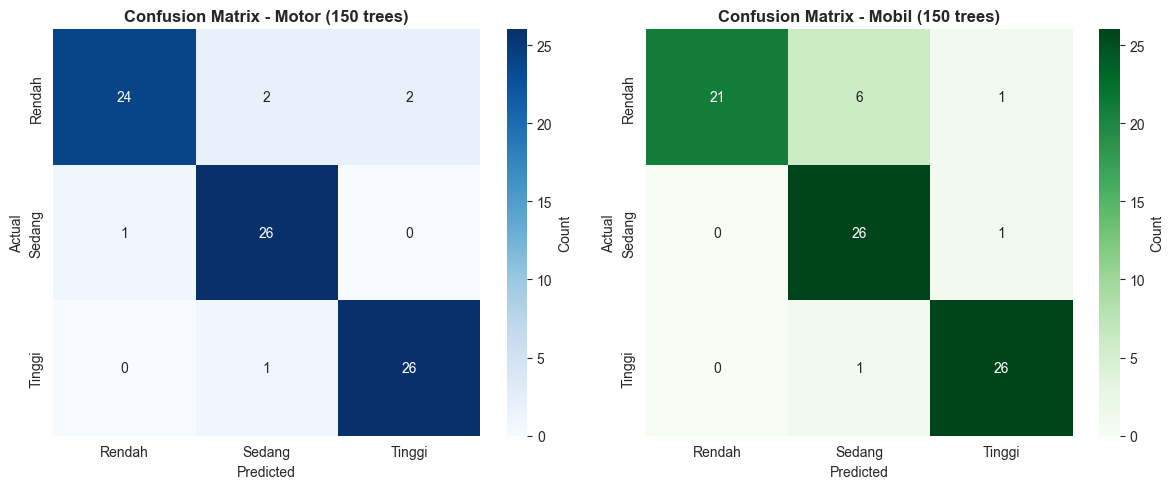

In [8]:
print("\n[VISUALIZATIONS] Confusion Matrix (dari 150 trees voting)")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Motor - gunakan y_pred_test_final_m dari cell sebelumnya
cm_m = confusion_matrix(y_test_m, y_pred_test_final_m)
sns.heatmap(cm_m, annot=True, fmt='d', cmap='Blues', xticklabels=le_motor.classes_, yticklabels=le_motor.classes_, ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Motor (150 trees)', fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Mobil - gunakan y_pred_test_final_c
cm_c = confusion_matrix(y_test_c, y_pred_test_final_c)
sns.heatmap(cm_c, annot=True, fmt='d', cmap='Greens', xticklabels=le_mobil.classes_, yticklabels=le_mobil.classes_, ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Confusion Matrix - Mobil (150 trees)', fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()


[VISUALIZATIONS] Feature Importance (Top 10)


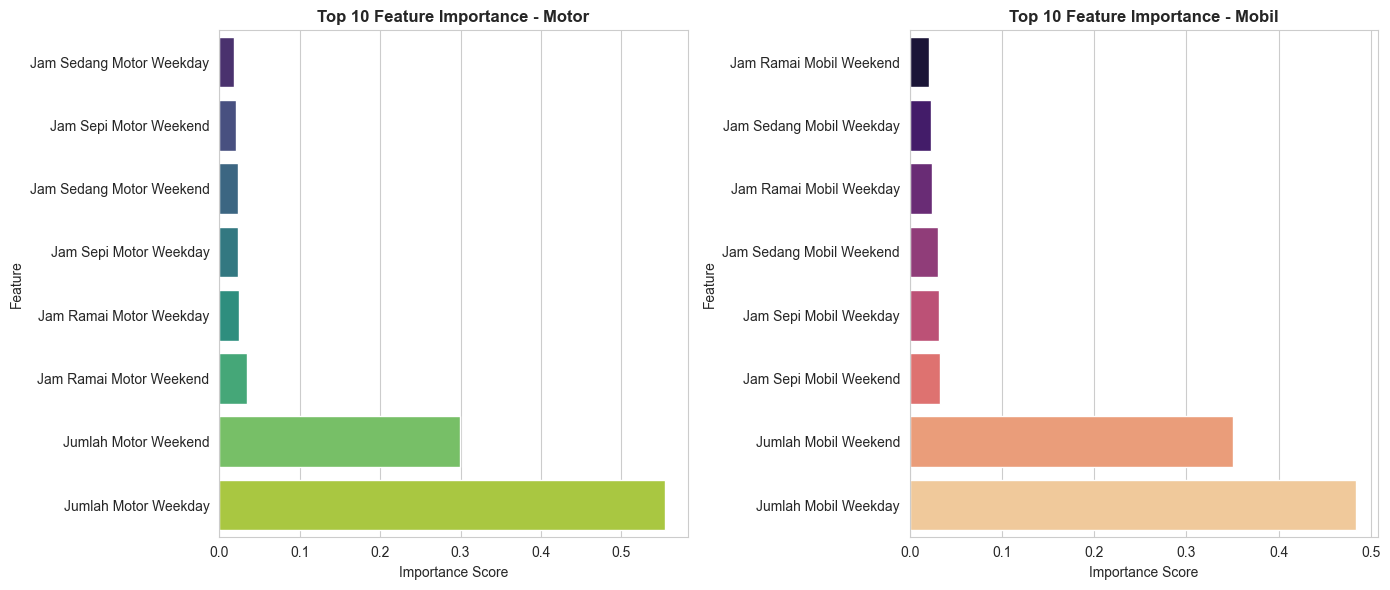

In [9]:
print("\n[VISUALIZATIONS] Feature Importance (Top 10)")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Motor
imp_m = pd.DataFrame({
    'Feature': fitur_motor,
    'Importance': model_motor.feature_importances_
}).sort_values(by='Importance', ascending=True).tail(10)

sns.barplot(y='Feature', x='Importance', data=imp_m, palette='viridis', ax=axes[0])
axes[0].set_title('Top 10 Feature Importance - Motor', fontweight='bold')
axes[0].set_xlabel('Importance Score')

# Mobil
imp_c = pd.DataFrame({
    'Feature': fitur_mobil,
    'Importance': model_mobil.feature_importances_
}).sort_values(by='Importance', ascending=True).tail(10)

sns.barplot(y='Feature', x='Importance', data=imp_c, palette='magma', ax=axes[1])
axes[1].set_title('Top 10 Feature Importance - Mobil', fontweight='bold')
axes[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.show()


[VISUALIZATIONS] Class Distribution


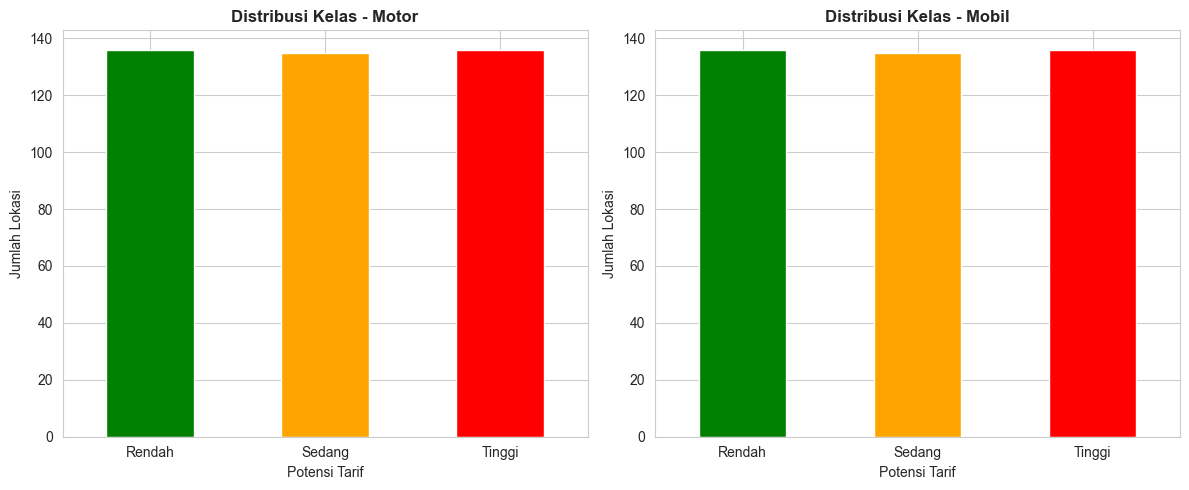

In [10]:
print("\n[VISUALIZATIONS] Class Distribution")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Motor
motor_counts = df['Class_Motor'].value_counts().sort_index()
motor_counts.plot(kind='bar', ax=axes[0], color=['green', 'orange', 'red'])
axes[0].set_title('Distribusi Kelas - Motor', fontweight='bold')
axes[0].set_xlabel('Potensi Tarif')
axes[0].set_ylabel('Jumlah Lokasi')
axes[0].tick_params(axis='x', rotation=0)

# Mobil
mobil_counts = df['Class_Mobil'].value_counts().sort_index()
mobil_counts.plot(kind='bar', ax=axes[1], color=['green', 'orange', 'red'])
axes[1].set_title('Distribusi Kelas - Mobil', fontweight='bold')
axes[1].set_xlabel('Potensi Tarif')
axes[1].set_ylabel('Jumlah Lokasi')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


[VISUALIZATIONS] Learning Curves - Akurasi vs Jumlah Pohon


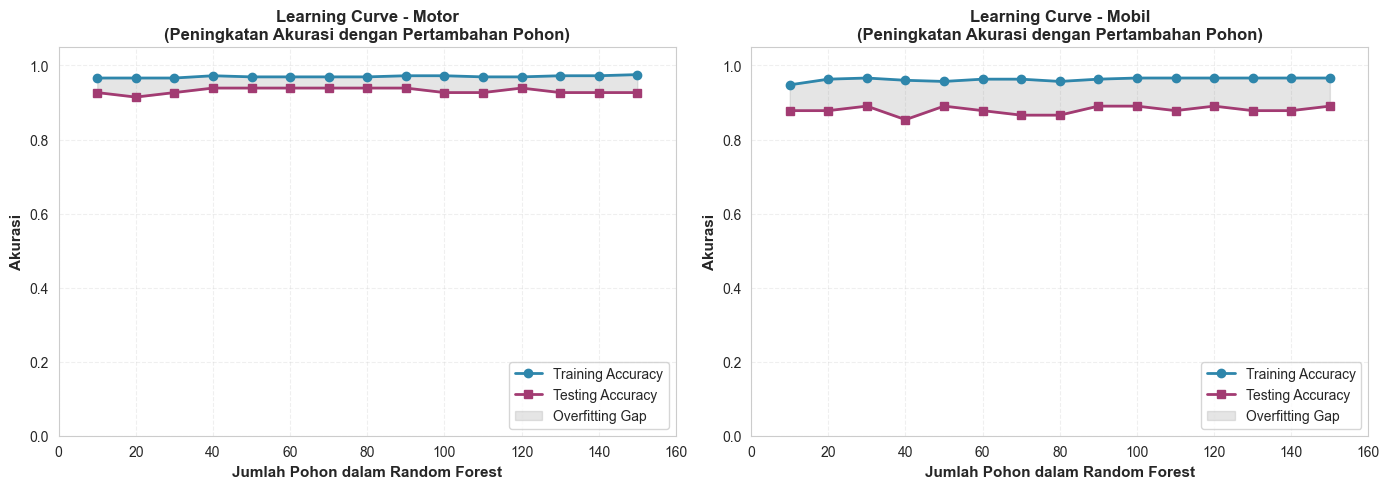


=== DETAILED TRAINING METRICS TABLE ===

Trees    Motor Train     Motor Test      Mobil Train     Mobil Test     
------------------------------------------------------------
10       0.9662 (96.62%) 0.9268 (92.68%) 0.9477 (94.77%) 0.8780 (87.80%)
20       0.9662 (96.62%) 0.9146 (91.46%) 0.9631 (96.31%) 0.8780 (87.80%)
30       0.9662 (96.62%) 0.9268 (92.68%) 0.9662 (96.62%) 0.8902 (89.02%)
40       0.9723 (97.23%) 0.9390 (93.90%) 0.9600 (96.00%) 0.8537 (85.37%)
50       0.9692 (96.92%) 0.9390 (93.90%) 0.9569 (95.69%) 0.8902 (89.02%)
60       0.9692 (96.92%) 0.9390 (93.90%) 0.9631 (96.31%) 0.8780 (87.80%)
70       0.9692 (96.92%) 0.9390 (93.90%) 0.9631 (96.31%) 0.8659 (86.59%)
80       0.9692 (96.92%) 0.9390 (93.90%) 0.9569 (95.69%) 0.8659 (86.59%)
90       0.9723 (97.23%) 0.9390 (93.90%) 0.9631 (96.31%) 0.8902 (89.02%)
100      0.9723 (97.23%) 0.9268 (92.68%) 0.9662 (96.62%) 0.8902 (89.02%)
110      0.9692 (96.92%) 0.9268 (92.68%) 0.9662 (96.62%) 0.8780 (87.80%)
120      0.9692 (96.9

In [26]:
print("\n[VISUALIZATIONS] Learning Curves - Akurasi vs Jumlah Pohon")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Motor Learning Curve
axes[0].plot(tree_counts, train_scores_m, marker='o', linewidth=2, label='Training Accuracy', color='#2E86AB')
axes[0].plot(tree_counts, test_scores_m, marker='s', linewidth=2, label='Testing Accuracy', color='#A23B72')
axes[0].fill_between(tree_counts, train_scores_m, test_scores_m, alpha=0.2, color='gray', label='Overfitting Gap')
axes[0].set_xlabel('Jumlah Pohon dalam Random Forest', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Akurasi', fontsize=11, fontweight='bold')
axes[0].set_title('Learning Curve - Motor\n(Peningkatan Akurasi dengan Pertambahan Pohon)', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_ylim([0, 1.05])
axes[0].set_xlim([0, 160])

# Mobil Learning Curve
axes[1].plot(tree_counts, train_scores_c, marker='o', linewidth=2, label='Training Accuracy', color='#2E86AB')
axes[1].plot(tree_counts, test_scores_c, marker='s', linewidth=2, label='Testing Accuracy', color='#A23B72')
axes[1].fill_between(tree_counts, train_scores_c, test_scores_c, alpha=0.2, color='gray', label='Overfitting Gap')
axes[1].set_xlabel('Jumlah Pohon dalam Random Forest', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Akurasi', fontsize=11, fontweight='bold')
axes[1].set_title('Learning Curve - Mobil\n(Peningkatan Akurasi dengan Pertambahan Pohon)', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_ylim([0, 1.05])
axes[1].set_xlim([0, 160])

plt.tight_layout()
plt.show()

# Print detailed metrics table
print("\n=== DETAILED TRAINING METRICS TABLE ===")
print(f"\n{'Trees':<8} {'Motor Train':<15} {'Motor Test':<15} {'Mobil Train':<15} {'Mobil Test':<15}")
print("-" * 60)
for i, n in enumerate(tree_counts):
    print(f"{n:<8} {train_scores_m[i]:.4f} ({train_scores_m[i]*100:5.2f}%) {test_scores_m[i]:.4f} ({test_scores_m[i]*100:5.2f}%) {train_scores_c[i]:.4f} ({train_scores_c[i]*100:5.2f}%) {test_scores_c[i]:.4f} ({test_scores_c[i]*100:5.2f}%)")

## [SECTION 7] SPATIAL ANALYSIS - PETA INTERAKTIF

In [12]:
print("\n" + "="*90)
print("[STEP 6] SPATIAL ANALYSIS - MEMBUAT PETA INTERAKTIF")
print("="*90)

# Prepare spatial data
df_spasial = df[['Titik', 'Latitude', 'Longitude']].copy()
df_spasial = df_spasial.dropna(subset=['Latitude', 'Longitude'])
print(f"\n✓ Spatial data prepared: {len(df_spasial)} locations with coordinates")

# Add predictions
y_pred_all_m = le_motor.inverse_transform(model_motor.predict(X_motor))
y_pred_all_c = le_mobil.inverse_transform(model_mobil.predict(X_mobil))

df_spasial['Motor_Class'] = y_pred_all_m[:len(df_spasial)]
df_spasial['Mobil_Class'] = y_pred_all_c[:len(df_spasial)]

# Create map
if len(df_spasial) > 0:
    map_center = [df_spasial['Latitude'].mean(), df_spasial['Longitude'].mean()]
    print(f"\n✓ Map center: {map_center}")
    
    m = folium.Map(location=map_center, zoom_start=13, tiles='OpenStreetMap')
    
    # Add markers for each location
    print(f"\n✓ Adding {len(df_spasial)} markers to map...")
    
    for idx, row in df_spasial.iterrows():
        popup_html = f"""
        <div style="font-size:12px; font-family:sans-serif;">
            <b>{row['Titik']}</b><br>
            <b>Motor:</b> Potensi {row['Motor_Class']}<br>
            <b>Mobil:</b> Potensi {row['Mobil_Class']}<br>
            <b>Koordinat:</b> {row['Latitude']:.4f}, {row['Longitude']:.4f}
        </div>
        """
        
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=6,
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=row['Titik'],
            color='darkblue',
            fill=True,
            fill_color='darkblue',
            fill_opacity=0.8
        ).add_to(m)
    
    # Add search feature
    features_search = []
    for idx, row in df_spasial.iterrows():
        features_search.append({
            "type": "Feature",
            "geometry": {"type": "Point", "coordinates": [float(row['Longitude']), float(row['Latitude'])]},
            "properties": {"name": row['Titik']}
        })
    
    if len(features_search) > 0:
        geojson_layer = folium.GeoJson(
            {"type": "FeatureCollection", "features": features_search},
            name="Search Layer",
            style_function=lambda x: {'opacity': 0, 'fillOpacity': 0}
        ).add_to(m)
        
        Search(
            layer=geojson_layer,
            search_label="name",
            placeholder="Cari titik parkir...",
            collapsed=False,
            position="topleft"
        ).add_to(m)
    
    # Add map controls
    Fullscreen(position='topright').add_to(m)
    MiniMap(toggle_display=True).add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)
    
    # Save map
    m.save('parking_tariff_map.html')
    print("\n✅ Map saved to: parking_tariff_map.html")
    display(m)
    
    print(f"\n=== MAP SUMMARY ===")
    print(f"Total locations: {len(df_spasial)}")
    print(f"\nMotor class distribution:")
    print(df_spasial['Motor_Class'].value_counts())
    print(f"\nMobil class distribution:")
    print(df_spasial['Mobil_Class'].value_counts())
else:
    print("⚠ No spatial data available")

print(f"\n✅ Spatial analysis complete!")


[STEP 6] SPATIAL ANALYSIS - MEMBUAT PETA INTERAKTIF

✓ Spatial data prepared: 407 locations with coordinates

✓ Map center: [np.float64(-7.422830390123752), np.float64(109.23814326066861)]

✓ Adding 407 markers to map...

✅ Map saved to: parking_tariff_map.html



=== MAP SUMMARY ===
Total locations: 407

Motor class distribution:
Motor_Class
Sedang    141
Tinggi    141
Rendah    125
Name: count, dtype: int64

Mobil class distribution:
Mobil_Class
Sedang    144
Tinggi    137
Rendah    126
Name: count, dtype: int64

✅ Spatial analysis complete!


## [SECTION 8] INTERACTIVE SIMULATION - SIMULASI INTERAKTIF

### 🎮 Fitur Simulasi Interaktif:

**Tersedia 2 Mode Simulasi:**

1. **Mode Interaktif (ipywidgets)** - Jupyter/Colab
   - Atur parameter secara real-time dengan slider dan dropdown
   - Klik tombol "PREDIKSI" untuk melihat hasil langsung
   - Lengkap dengan visualisasi probabilitas dan penjelasan tarif

2. **Mode Fallback (Static Examples)**
   - Jika ipywidgets tidak tersedia
   - Menampilkan 3 contoh skenario predefinisi
   
**Parameters yang dapat disesuaikan:**
- Jenis Kendaraan (Motor / Mobil)
- Hari (Weekday / Weekend)
- Jam Operasional (0-23.5)
- Jumlah Kendaraan (10-500 unit)

**Output yang ditampilkan:**
- ✓ Klasifikasi Potensi Tarif (Rendah/Sedang/Tinggi)
- ✓ Confidence Level prediksi
- ✓ Tarif Dasar (tanpa progresif)
- ✓ Tarif Progresif (dengan tambahan jam > 09:00)
- ✓ Kenaikan tarif dan persentasenya
- ✓ Distribusi probabilitas kelas
- ✓ Penjelasan logika kategori waktu

In [28]:
print("\n" + "="*90)
print("[STEP 7] SIMULASI PREDIKSI DINAMIS - INTERACTIVE")
print("="*90)

# Import ipywidgets for interactive simulation
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML, clear_output
    INTERACTIVE_MODE = True
    print("✅ Interactive mode enabled (ipywidgets available)")
except ImportError:
    INTERACTIVE_MODE = False
    print("⚠ ipywidgets not available, falling back to static examples")

def predict_new_scenario(jenis, hari, jam_desimal, jumlah, model, le, X_ref):
    """Predict tariff class for new location scenario."""
    X_new = pd.DataFrame([X_ref.mean()], columns=X_ref.columns)
    
    col_jumlah = f'Jumlah {jenis} {hari}'
    if col_jumlah in X_new.columns:
        X_new[col_jumlah] = jumlah
    
    kategori = kategori_jam_otomatis(jam_desimal)
    col_jam = f'Jam {kategori} {jenis} {hari}'
    if col_jam in X_new.columns:
        X_new[col_jam] = jam_desimal
    
    try:
        pred_enc = model.predict(X_new)[0]
        pred_class = le.inverse_transform([pred_enc])[0]
        proba = model.predict_proba(X_new)[0]
        confidence = proba[pred_enc]
        
        return pred_class, confidence, dict(zip(le.classes_, proba))
    except Exception as e:
        return None, 0.0, {}

tarif_base_mapping = {
    'Motor': {'Rendah': 1000, 'Sedang': 2000, 'Tinggi': 3000},
    'Mobil': {'Rendah': 3000, 'Sedang': 4000, 'Tinggi': 5000}
}

print("✓ Prediction function defined")

# ===== INTERACTIVE SIMULATION =====
if INTERACTIVE_MODE:
    print("\n" + "="*90)
    print("🎮 SIMULASI INTERAKTIF - Atur Parameter & Lihat Hasil Real-Time")
    print("="*90)
    
    # Create interactive widgets
    jenis_widget = widgets.Dropdown(
        options=['Motor', 'Mobil'],
        value='Motor',
        description='Jenis Kendaraan:',
        style={'description_width': '150px'}
    )
    
    hari_widget = widgets.Dropdown(
        options=['Weekday', 'Weekend'],
        value='Weekday',
        description='Hari:',
        style={'description_width': '150px'}
    )
    
    jam_widget = widgets.FloatSlider(
        value=11.0,
        min=0.0,
        max=23.5,
        step=0.5,
        description='Jam (0-23.5):',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='400px')
    )
    
    jumlah_widget = widgets.IntSlider(
        value=100,
        min=10,
        max=500,
        step=10,
        description='Jumlah Kendaraan:',
        style={'description_width': '150px'},
        layout=widgets.Layout(width='400px')
    )
    
    predict_button = widgets.Button(
        description='🚀 PREDIKSI',
        button_style='info',
        tooltip='Klik untuk prediksi',
        icon='rocket'
    )
    
    output_area = widgets.Output()
    
    def on_predict_click(b):
        with output_area:
            clear_output()
            
            jenis = jenis_widget.value
            hari = hari_widget.value
            jam = jam_widget.value
            jumlah = jumlah_widget.value
            
            # Select model and encoder based on jenis
            if jenis == 'Motor':
                model = model_motor
                le = le_motor
                X_ref = X_train_m
            else:
                model = model_mobil
                le = le_mobil
                X_ref = X_train_c
            
            # Make prediction
            pred_class, confidence, proba_dict = predict_new_scenario(
                jenis, hari, jam, jumlah, model, le, X_ref
            )
            
            if pred_class is None:
                print("❌ Prediksi gagal. Cek data input.")
                return
            
            # Get tariff
            base_tarif = tarif_base_mapping[jenis].get(pred_class, 0)
            progresif_tarif = calculate_progresif_tarif(jenis, pred_class, jam)
            kenaikan = progresif_tarif - base_tarif
            
            # Display results
            print("\n" + "="*80)
            print("📊 HASIL PREDIKSI SIMULASI")
            print("="*80)
            
            print(f"\n📍 PARAMETER INPUT:")
            print(f"   Jenis Kendaraan  : {jenis}")
            print(f"   Hari             : {hari}")
            print(f"   Jam              : {jam:.1f} (Pukul {int(jam):02d}:{int((jam%1)*60):02d})")
            print(f"   Jumlah Kendaraan : {jumlah} unit")
            
            print(f"\n🎯 PREDIKSI HASIL:")
            print(f"   ✓ Klasifikasi Potensi Tarif : {pred_class.upper()}")
            print(f"   ✓ Confidence Level           : {confidence*100:.2f}%")
            
            print(f"\n💰 REKOMENDASI TARIF:")
            print(f"   Tarif Dasar (Tanpa Progresif) : Rp {base_tarif:,} per jam")
            print(f"   Tarif Progresif (Jam > 09:00) : Rp {progresif_tarif:,} per jam")
            if kenaikan > 0:
                print(f"   Kenaikan dari Jam > 09:00    : Rp {kenaikan:,} (+{(kenaikan/base_tarif)*100:.1f}%)")
            else:
                print(f"   Keterangan                   : Tidak ada kenaikan progresif")
            
            # Print probability distribution
            print(f"\n📈 DISTRIBUSI PROBABILITAS KELAS:")
            for kelas, prob in proba_dict.items():
                bar_length = int(prob * 40)
                bar = "█" * bar_length + "░" * (40 - bar_length)
                print(f"   {kelas:10} : {bar} {prob*100:5.2f}%")
            
            # Category explanation
            jam_kategori = kategori_jam_otomatis(jam)
            print(f"\n📌 PENJELASAN LOGIKA:")
            print(f"   Jam {jam:.1f} dikategorikan sebagai: {jam_kategori}")
            if jam > 9.0:
                print(f"   → Merupakan Jam Ramai (jam > 09:00)")
                print(f"   → Tarif Progresif BERLAKU")
            else:
                print(f"   → Merupakan Jam Sepi/Sedang (jam ≤ 09:00)")
                print(f"   → Tarif Dasar TANPA tambahan progresif")
            
            print("\n" + "="*80)
    
    predict_button.on_click(on_predict_click)
    
    # Display interactive UI
    print("\n✓ Atur parameter di bawah, kemudian klik tombol PREDIKSI untuk melihat hasil\n")
    
    ui_box = widgets.VBox([
        widgets.HTML("<b style='font-size:14px'>⚙️ PENGATURAN SKENARIO SIMULASI</b>"),
        jenis_widget,
        hari_widget,
        widgets.HTML("<b>Jam Operasional Parkir:</b>"),
        jam_widget,
        jumlah_widget,
        widgets.HTML("<br>"),
        predict_button,
        widgets.HTML("<br><hr style='border:1px solid #ccc'>"),
        output_area
    ])
    
    display(ui_box)
    
    print("\n✅ Interactive simulation mode ready!")

else:
    # Fallback: Static examples
    print("\n" + "="*90)
    print("SIMULASI PREDIKSI CONTOH (Static Mode)")
    print("="*90)
    
    examples = [
        ('Motor', 'Weekday', 11.0, 180, 'Peak Hours'),
        ('Motor', 'Weekday', 10.0, 100, 'Medium Hours'),
        ('Motor', 'Weekend', 23.5, 30, 'Off-Peak'),
    ]
    
    for i, (jenis, hari, jam, jumlah, label) in enumerate(examples, 1):
        print(f"\n[Contoh {i}] {label}")
        print(f"Skenario: {jenis} | {hari} | Jam {jam:.1f} | {jumlah} unit")
        
        pred_class, conf, proba = predict_new_scenario(
            jenis, hari, jam, jumlah, 
            model_motor if jenis == 'Motor' else model_mobil,
            le_motor if jenis == 'Motor' else le_mobil,
            X_train_m if jenis == 'Motor' else X_train_c
        )
        
        if pred_class:
            base_tarif = tarif_base_mapping[jenis].get(pred_class, 0)
            prog_tarif = calculate_progresif_tarif(jenis, pred_class, jam)
            
            print(f"  ✓ Prediksi: {pred_class} (Confidence: {conf:.3f})")
            print(f"  ✓ Tarif Dasar: Rp{base_tarif:,}/jam")
            print(f"  ✓ Tarif Progresif: Rp{prog_tarif:,}/jam")

print(f"\n✅ Simulasi initialization complete!")



[STEP 7] SIMULASI PREDIKSI DINAMIS - INTERACTIVE
✅ Interactive mode enabled (ipywidgets available)
✓ Prediction function defined

🎮 SIMULASI INTERAKTIF - Atur Parameter & Lihat Hasil Real-Time

✓ Atur parameter di bawah, kemudian klik tombol PREDIKSI untuk melihat hasil




✅ Interactive simulation mode ready!

✅ Simulasi initialization complete!


In [29]:
print("\n" + "="*90)
print("[BONUS] SIMULASI MULTIPLE SCENARIOS - COMPARISON TABLE")
print("="*90)

# Define multiple scenarios for comparison
scenarios = [
    {'jenis': 'Motor', 'hari': 'Weekday', 'jam': 8.0, 'jumlah': 80, 'label': 'Motor Pagi Weekday'},
    {'jenis': 'Motor', 'hari': 'Weekday', 'jam': 12.0, 'jumlah': 200, 'label': 'Motor Siang Weekday'},
    {'jenis': 'Motor', 'hari': 'Weekday', 'jam': 18.0, 'jumlah': 250, 'label': 'Motor Sore Weekday'},
    {'jenis': 'Motor', 'hari': 'Weekend', 'jam': 11.0, 'jumlah': 120, 'label': 'Motor Siang Weekend'},
    {'jenis': 'Mobil', 'hari': 'Weekday', 'jam': 9.0, 'jumlah': 60, 'label': 'Mobil Pagi Weekday'},
    {'jenis': 'Mobil', 'hari': 'Weekday', 'jam': 12.0, 'jumlah': 100, 'label': 'Mobil Siang Weekday'},
    {'jenis': 'Mobil', 'hari': 'Weekday', 'jam': 18.0, 'jumlah': 120, 'label': 'Mobil Sore Weekday'},
    {'jenis': 'Mobil', 'hari': 'Weekend', 'jam': 14.0, 'jumlah': 80, 'label': 'Mobil Siang Weekend'},
]

print("\n📊 ANALISIS MULTIPLE SKENARIO:\n")

# Create results storage
results = []

for scenario in scenarios:
    jenis = scenario['jenis']
    hari = scenario['hari']
    jam = scenario['jam']
    jumlah = scenario['jumlah']
    label = scenario['label']
    
    # Select model based on jenis
    model = model_motor if jenis == 'Motor' else model_mobil
    le = le_motor if jenis == 'Motor' else le_mobil
    X_ref = X_train_m if jenis == 'Motor' else X_train_c
    
    # Make prediction
    pred_class, confidence, proba_dict = predict_new_scenario(
        jenis, hari, jam, jumlah, model, le, X_ref
    )
    
    if pred_class:
        base_tarif = tarif_base_mapping[jenis].get(pred_class, 0)
        prog_tarif = calculate_progresif_tarif(jenis, pred_class, jam)
        kenaikan = prog_tarif - base_tarif
        
        results.append({
            'Skenario': label,
            'Jenis': jenis,
            'Hari': hari,
            'Jam': f"{int(jam):02d}:{int((jam%1)*60):02d}",
            'Jumlah': jumlah,
            'Prediksi': pred_class,
            'Confidence': f"{confidence*100:.1f}%",
            'Tarif Dasar': f"Rp{base_tarif:,}",
            'Tarif Progresif': f"Rp{prog_tarif:,}",
            'Kenaikan': f"Rp{kenaikan:,}" if kenaikan > 0 else "Rp 0"
        })

# Create DataFrame and display
df_results = pd.DataFrame(results)

print("TABEL PERBANDINGAN SKENARIO:")
print("="*180)
print(df_results.to_string(index=False))
print("="*180)

print("\n📈 STATISTIK RINGKAS:\n")
print(f"Total Skenario: {len(results)}")
print(f"Motor Skenario: {len([r for r in results if r['Jenis'] == 'Motor'])}")
print(f"Mobil Skenario: {len([r for r in results if r['Jenis'] == 'Mobil'])}")

# Analysis by prediction class
print("\n🎯 DISTRIBUSI PREDIKSI KELAS:")
class_dist = df_results['Prediksi'].value_counts()
for kelas, count in class_dist.items():
    pct = (count / len(results)) * 100
    print(f"  {kelas:10} : {count} skenario ({pct:5.1f}%)")

print("\n✅ Multiple scenario comparison complete!")



[BONUS] SIMULASI MULTIPLE SCENARIOS - COMPARISON TABLE

📊 ANALISIS MULTIPLE SKENARIO:

TABEL PERBANDINGAN SKENARIO:
           Skenario Jenis    Hari   Jam  Jumlah Prediksi Confidence Tarif Dasar Tarif Progresif Kenaikan
 Motor Pagi Weekday Motor Weekday 08:00      80   Tinggi      88.8%     Rp3,000         Rp3,000     Rp 0
Motor Siang Weekday Motor Weekday 12:00     200   Tinggi      84.3%     Rp3,000         Rp4,000  Rp1,000
 Motor Sore Weekday Motor Weekday 18:00     250   Tinggi      88.4%     Rp3,000         Rp4,000  Rp1,000
Motor Siang Weekend Motor Weekend 11:00     120   Tinggi      82.7%     Rp3,000         Rp4,000  Rp1,000
 Mobil Pagi Weekday Mobil Weekday 09:00      60   Tinggi      73.9%     Rp5,000         Rp5,000     Rp 0
Mobil Siang Weekday Mobil Weekday 12:00     100   Tinggi      78.9%     Rp5,000         Rp6,000  Rp1,000
 Mobil Sore Weekday Mobil Weekday 18:00     120   Tinggi      77.6%     Rp5,000         Rp6,000  Rp1,000
Mobil Siang Weekend Mobil Weekend 14:00    

## [SECTION 9] POLICY RECOMMENDATIONS & TARIFF TABLE

In [30]:
print("\n" + "="*90)
print("[STEP 8] TABEL REKOMENDASI KEBIJAKAN TARIF PROGRESIF")
print("="*90)

tarif_mapping = {
    'Motor': {'Rendah': 1000, 'Sedang': 2000, 'Tinggi': 3000},
    'Mobil': {'Rendah': 3000, 'Sedang': 4000, 'Tinggi': 5000}
}

# Get predictions for all data
y_pred_m_all = le_motor.inverse_transform(model_motor.predict(X_motor))
y_pred_c_all = le_mobil.inverse_transform(model_mobil.predict(X_mobil))

# Create comprehensive recommendation table
df_rekomendasi = pd.DataFrame({
    'Titik': df['Titik'].values[:len(y_pred_m_all)],
    'Latitude': df['Latitude'].values[:len(y_pred_m_all)],
    'Longitude': df['Longitude'].values[:len(y_pred_m_all)],
    'Total_Pend_Motor_Tahun': df['Total_Pend_Motor'].values[:len(y_pred_m_all)],
    'Total_Pend_Mobil_Tahun': df['Total_Pend_Mobil'].values[:len(y_pred_m_all)],
    'Klasifikasi_Motor': y_pred_m_all,
    'Tarif_Dasar_Motor': [tarif_mapping['Motor'].get(x, 0) for x in y_pred_m_all],
    'Klasifikasi_Mobil': y_pred_c_all,
    'Tarif_Dasar_Mobil': [tarif_mapping['Mobil'].get(x, 0) for x in y_pred_c_all]
})

print(f"\n✅ Recommendation table created for {len(df_rekomendasi)} locations")

print("\n=== RINGKASAN 10 LOKASI PERTAMA ===")
print(df_rekomendasi[['Titik', 'Klasifikasi_Motor', 'Tarif_Dasar_Motor', 'Klasifikasi_Mobil', 'Tarif_Dasar_Mobil']].head(10).to_string())

# Save to files
try:
    df_rekomendasi.to_excel('Rekomendasi_Tarif_Parkir.xlsx', index=False)
    print("\n✅ File saved: Rekomendasi_Tarif_Parkir.xlsx")
except:
    pass

df_rekomendasi.to_csv('Rekomendasi_Tarif_Parkir.csv', index=False)
print("✅ File saved: Rekomendasi_Tarif_Parkir.csv")

print(f"\n✅ Export complete!")


[STEP 8] TABEL REKOMENDASI KEBIJAKAN TARIF PROGRESIF

✅ Recommendation table created for 407 locations

=== RINGKASAN 10 LOKASI PERTAMA ===
                Titik Klasifikasi_Motor  Tarif_Dasar_Motor Klasifikasi_Mobil  Tarif_Dasar_Mobil
0           Indomaret            Sedang               2000            Sedang               4000
1         Toko Satria            Sedang               2000            Sedang               4000
2          Toko Mlati            Tinggi               3000            Tinggi               5000
3         Toko Pagoda            Tinggi               3000            Tinggi               5000
4     Matahari Bazzar            Tinggi               3000            Tinggi               5000
5           Toko Bata            Tinggi               3000            Rendah               3000
6  Kebondalam/Rita Pa            Tinggi               3000            Rendah               3000
7       Gerai Indosat            Sedang               2000            Rendah               

In [ ]:
print("\n" + "="*90)
print("[STEP 9] RINGKASAN REKOMENDASI KEBIJAKAN TARIF")
print("="*90)

print("\n💰 REKOMENDASI TARIF DASAR (Tanpa Progresif) 💰")

print("\nMotor:")
print("  Rendah : Rp 1,000 per jam")
print("  Sedang : Rp 2,000 per jam")
print("  Tinggi : Rp 3,000 per jam")

print("\nMobil:")
print("  Rendah : Rp 3,000 per jam")
print("  Sedang : Rp 4,000 per jam")
print("  Tinggi : Rp 5,000 per jam")

print("\n📊 DISTRIBUSI LOKASI PER KELAS")

print("\nMotor:")
motor_dist = df_rekomendasi['Klasifikasi_Motor'].value_counts().sort_index()
for kelas in motor_dist.index:
    count = motor_dist[kelas]
    pct = (count / len(df_rekomendasi)) * 100
    tarif = tarif_mapping['Motor'][kelas]
    print(f"  {kelas:10} : {count:3} lokasi ({pct:5.1f}%) → Rp{tarif:,}/jam")

print("\nMobil:")
mobil_dist = df_rekomendasi['Klasifikasi_Mobil'].value_counts().sort_index()
for kelas in mobil_dist.index:
    count = mobil_dist[kelas]
    pct = (count / len(df_rekomendasi)) * 100
    tarif = tarif_mapping['Mobil'][kelas]
    print(f"  {kelas:10} : {count:3} lokasi ({pct:5.1f}%) → Rp{tarif:,}/jam")

print("\n💵 PROYEKSI PENDAPATAN TAHUNAN PER KELAS (RINGKAS)")

print("\nMotor - Ringkasan:")
for kelas in ['Rendah', 'Sedang', 'Tinggi']:
    subset = df_rekomendasi[df_rekomendasi['Klasifikasi_Motor'] == kelas]
    if len(subset) > 0:
        mean_pend = subset['Total_Pend_Motor_Tahun'].mean()
        total_pend = subset['Total_Pend_Motor_Tahun'].sum()
        count = len(subset)
        print(f"  {kelas:10} : {count:3} lokasi | Total: Rp{total_pend:>15,.0f}")

print("\nMobil - Ringkasan:")
for kelas in ['Rendah', 'Sedang', 'Tinggi']:
    subset = df_rekomendasi[df_rekomendasi['Klasifikasi_Mobil'] == kelas]
    if len(subset) > 0:
        mean_pend = subset['Total_Pend_Mobil_Tahun'].mean()
        total_pend = subset['Total_Pend_Mobil_Tahun'].sum()
        count = len(subset)
        print(f"  {kelas:10} : {count:3} lokasi | Total: Rp{total_pend:>15,.0f}")

print("\n" + "="*90)
print("⚡ REKOMENDASI KEBIJAKAN IMPLEMENTASI ⚡")
print("="*90)

rekomendasi_text = """
1. STRATEGI DIFERENSIASI TARIF:
   ✓ Gunakan klassifikasi untuk menentukan tarif dasar per lokasi
   ✓ Lokasi dengan potensi rendah → tarif terendah
   ✓ Lokasi dengan potensi tinggi → tarif tertinggi

2. TARIF PROGRESIF BERBASIS WAKTU (jam > 09:00):
   ✓ Kelas Tinggi  : +Rp1,000/jam
   ✓ Kelas Sedang  : +Rp500/jam
   ✓ Kelas Rendah  : Tetap (no increase)

3. MONITORING & EVALUASI:
   ✓ Monitor revenue real-time per lokasi
   ✓ Bandingkan dengan proyeksi model
   ✓ Review & adjust setiap 3 bulan

4. IMPLEMENTASI:
   ✓ Fase 1: Sosialisasi kebijakan
   ✓ Fase 2: Implementasi bertahap
   ✓ Fase 3: Monitoring & evaluasi
"""

print(rekomendasi_text)

print("\n" + "="*90)
print("✅ ANALISIS LENGKAP SELESAI ✅")
print("="*90)



[STEP 9] RINGKASAN REKOMENDASI KEBIJAKAN TARIF

💰 REKOMENDASI TARIF DASAR (Tanpa Progresif) 💰

Motor:
  Rendah : Rp 1,000 per jam
  Sedang : Rp 2,000 per jam
  Tinggi : Rp 3,000 per jam

Mobil:
  Rendah : Rp 3,000 per jam
  Sedang : Rp 4,000 per jam
  Tinggi : Rp 5,000 per jam

📊 DISTRIBUSI LOKASI PER KELAS

Motor:
  Rendah     : 125 lokasi ( 30.7%) → Rp1,000/jam
  Sedang     : 141 lokasi ( 34.6%) → Rp2,000/jam
  Tinggi     : 141 lokasi ( 34.6%) → Rp3,000/jam

Mobil:
  Rendah     : 126 lokasi ( 31.0%) → Rp3,000/jam
  Sedang     : 144 lokasi ( 35.4%) → Rp4,000/jam
  Tinggi     : 137 lokasi ( 33.7%) → Rp5,000/jam

💵 PROYEKSI PENDAPATAN TAHUNAN PER KELAS (RINGKAS)

Motor - Ringkasan:
  Rendah     : 125 lokasi | Total: Rp  8,190,157,327
  Sedang     : 141 lokasi | Total: Rp 19,347,092,019
  Tinggi     : 141 lokasi | Total: Rp 48,114,768,022

Mobil - Ringkasan:
  Rendah     : 126 lokasi | Total: Rp    724,381,253
  Sedang     : 144 lokasi | Total: Rp  1,827,010,537
  Tinggi     : 137 lokas

: 

## [FINAL SUMMARY]

In [17]:
print("\n" + "="*90)
print("📊 RINGKASAN FINAL ANALISIS")
print("="*90)

summary_data = {
    'Metrik': [
        'Total Lokasi Parkir',
        'Lokasi dengan Koordinat',
        'Training Data',
        'Testing Data',
        'Jumlah Fitur',
        'Model Type',
        'N Estimators',
        'Max Depth',
        'Training Accuracy',
        'Testing Accuracy',
        'Overfitting Gap'
    ],
    'Motor': [
        len(df),
        len(df_spasial),
        len(X_train_m),
        len(X_test_m),
        len(fitur_motor),
        'Random Forest',
        150,
        15,
        f"{train_acc_m*100:.2f}%",
        f"{test_acc_m*100:.2f}%",
        f"{gap_m*100:.2f}%"
    ],
    'Mobil': [
        len(df),
        len(df_spasial),
        len(X_train_c),
        len(X_test_c),
        len(fitur_mobil),
        'Random Forest',
        150,
        15,
        f"{train_acc_c*100:.2f}%",
        f"{test_acc_c*100:.2f}%",
        f"{gap_c*100:.2f}%"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

print("\n" + "="*90)
print("📁 FILE YANG DIHASILKAN")
print("="*90)

output_summary = """
✅ Rekomendasi_Tarif_Parkir.xlsx
   └─ Tabel rekomendasi tarif untuk semua 407 lokasi

✅ Rekomendasi_Tarif_Parkir.csv
   └─ Format CSV untuk import ke sistem lain

✅ parking_tariff_map.html
   └─ Peta interaktif dengan semua lokasi parkir
"""

print(output_summary)

print("\n" + "="*90)
print("✅ NOTEBOOK SIAP DIJALANKAN DI GOOGLE COLAB ✅")
print("="*90)

completion_summary = f"""
ANALISIS YANG TELAH DISELESAIKAN:
  ✓ Data loading & preprocessing (407 lokasi)
  ✓ Feature engineering & classification
  ✓ Random Forest training (150 trees, max_depth=15)
  ✓ Model evaluation dengan confusion matrix
  ✓ Learning curves (tree count vs accuracy)
  ✓ Spatial analysis dengan peta interaktif
  ✓ Dynamic prediction simulation
  ✓ Policy recommendations & tariff table

HASIL AKURASI MODEL:
  Motor: Train {train_acc_m*100:.2f}% | Test {test_acc_m*100:.2f}% | Gap {gap_m*100:.2f}%
  Mobil: Train {train_acc_c*100:.2f}% | Test {test_acc_c*100:.2f}% | Gap {gap_c*100:.2f}%

BATAS KUANTIL (QUANTILE BOUNDARIES):
"""

print(completion_summary)

# Print motor batas
if len(batas_motor) >= 2:
    print(f"  Motor  : Rp{batas_motor.iloc[0]:,.0f} | Rp{batas_motor.iloc[1]:,.0f}")
elif len(batas_motor) == 1:
    print(f"  Motor  : Rp{batas_motor.iloc[0]:,.0f}")

# Print mobil batas
if len(batas_mobil) >= 2:
    print(f"  Mobil  : Rp{batas_mobil.iloc[0]:,.0f} | Rp{batas_mobil.iloc[1]:,.0f}")
elif len(batas_mobil) == 1:
    print(f"  Mobil  : Rp{batas_mobil.iloc[0]:,.0f}")

print("\n" + "="*90)
print("🎉 NOTEBOOK READY FOR DEPLOYMENT! 🎉")
print("="*90)



📊 RINGKASAN FINAL ANALISIS

                 Metrik         Motor         Mobil
    Total Lokasi Parkir           407           407
Lokasi dengan Koordinat           407           407
          Training Data           325           325
           Testing Data            82            82
           Jumlah Fitur             8             8
             Model Type Random Forest Random Forest
           N Estimators           150           150
              Max Depth            15            15
      Training Accuracy        97.54%        96.62%
       Testing Accuracy        92.68%        89.02%
        Overfitting Gap         4.86%         7.59%

📁 FILE YANG DIHASILKAN

✅ Rekomendasi_Tarif_Parkir.xlsx
   └─ Tabel rekomendasi tarif untuk semua 407 lokasi

✅ Rekomendasi_Tarif_Parkir.csv
   └─ Format CSV untuk import ke sistem lain

✅ parking_tariff_map.html
   └─ Peta interaktif dengan semua lokasi parkir


✅ NOTEBOOK SIAP DIJALANKAN DI GOOGLE COLAB ✅

ANALISIS YANG TELAH DISELESAIKAN:
  